In [1]:
import os
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
#from google.colab import drive

## LOAD S2 BANDS

In [2]:
dataset=gdal.Open('Data/Nagar/Nagar_composite_S2_7bands.tif',gdal.GA_ReadOnly)

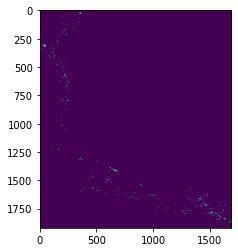

In [3]:
band = dataset.GetRasterBand(7)
arr = band.ReadAsArray()
plt.imshow(arr)

In [4]:
unique, counts = np.unique(arr, return_counts=True)
dict(zip(unique, counts))


{0.0: 3234649, 255.0: 4623}

In [5]:
sizeX=32
sizeY=32

In [6]:
bandList=[]
for i in range (1,8):
    band = dataset.GetRasterBand(i)
    arr = band.ReadAsArray()
    ## drop some portion of the region
    #l=list(range(800,arr.shape[0]))
    #arr=np.delete(arr,l,0)
    #l=list(range(0,370))
    #arr=np.delete(arr,l,1)
    #l=list(range(900,arr.shape[1]))
    #arr=np.delete(arr,l,1)
    
    row=arr.shape[0]-(int(arr.shape[0]/sizeX)*sizeX)
    col=arr.shape[1]-(int(arr.shape[1]/sizeY)*sizeY)
    l=list(range(arr.shape[0]-row,arr.shape[0]))
    x=np.delete(arr,l,0)
    l=list(range(arr.shape[1]-col,arr.shape[1]))
    x=np.delete(x,l,1)
    
    arr=x
    bandList.append(arr)

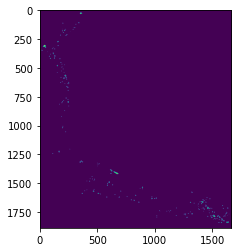

In [7]:
plt.imshow(bandList[6])
arr=bandList[6]

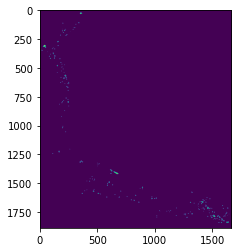

In [8]:
multiDimArray=np.zeros((arr.shape[0],arr.shape[1],8))
for i in range (1,8):
    band=dataset.GetRasterBand(i)
    arr=band.ReadAsArray()
    ## drop some portion of the region
    #l=list(range(800,arr.shape[0]))
    #arr=np.delete(arr,l,0)
    #l=list(range(0,370))
    #arr=np.delete(arr,l,1)
    #l=list(range(900,arr.shape[1]))
    #arr=np.delete(arr,l,1)
    
    ## Making size of tiff divisible by 32
    row=arr.shape[0]-(int(arr.shape[0]/sizeX)*sizeX)
    col=arr.shape[1]-(int(arr.shape[1]/sizeY)*sizeY)
    l=list(range(arr.shape[0]-row,arr.shape[0]))
    x=np.delete(arr,l,0)
    l=list(range(arr.shape[1]-col,arr.shape[1]))
    x=np.delete(x,l,1)
    if i==7: ## Last band has to be binary
        x = ((x - x.min()) * (1/(x.max() - x.min()))).astype('uint8')    
    #x = ((x - x.min()) * (1/(x.max() - x.min()))).astype('uint8')
    
    arr=x
    multiDimArray[:,:,i-1]=arr
plt.imshow(multiDimArray[:,:,6])    

In [10]:
indices_one = multiDimArray[:,:,6] == 1
indices_zero = multiDimArray[:,:,6] == 0
multiDimArray[:,:,7][indices_one] = 0 # replacing 1s with 0s
multiDimArray[:,:,7][indices_zero] = 1 # replacing 0s with 1s


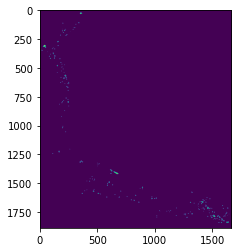

In [11]:
plt.imshow(multiDimArray[:,:,6])

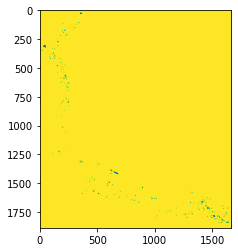

In [12]:
plt.imshow( multiDimArray[:,:,7])

In [9]:
np.unique(multiDimArray[:,:,6])

array([0., 1.])

In [13]:
np.unique(multiDimArray[:,:,7])

array([0., 1.])

## Patching

In [14]:
from sklearn.feature_extraction import image
import cv2

In [15]:
multiDimArray.shape

(1888, 1664, 8)

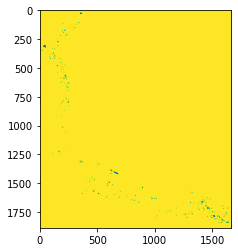

In [17]:
X=multiDimArray
plt.imshow(X[:,:,7])

In [18]:
patchH=sizeX
patchW=sizeY

In [19]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [20]:
multiDimArray.shape

(1888, 1664, 8)

In [21]:
x=blockshaped(multiDimArray[:,:,0], nrows=patchH, ncols=patchW)
x.shape

(3068, 32, 32)

In [22]:
patches=np.zeros((x.shape[0],x.shape[1],x.shape[2],8))
j=0
for i in range (0,8):
    patches[:,:,:,j]=blockshaped(multiDimArray[:,:,i], nrows=patchH, ncols=patchW)
    j=j+1   

## Removing uniLabel patches

In [23]:
filterPatches=[]
for i in range (patches.shape[0]):
    if np.unique(patches[i][:,:,6]).shape[0]==2:
        filterPatches.append(patches[i])

In [24]:
filterPatches=np.array(filterPatches)
filterPatches.shape

(163, 32, 32, 8)

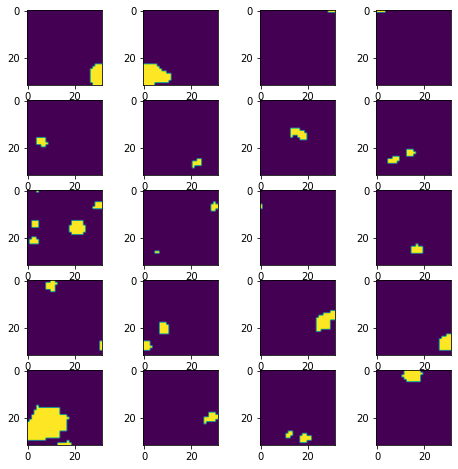

In [25]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = filterPatches[i-1][:,:,6]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()